In [ ]:
# Prerequisites: pip install requests
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install tqdm
!pip install networkx
!pip install scikit-learn
!pip install python-Levenshtein
!pip install scipy
!pip install neo4j
!pip install torch
!pip install gravis
!pip install csv
!pip install Levenshtein
!pip install collections

In [18]:
# Core Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.cm as cm
import random
import itertools
import time

# Visualization
import gravis as gv
import matplotlib.patches as mpatches
import matplotlib.colors as colors 

# NetworkX
import networkx as nx
from networkx.algorithms.components import connected_components
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.distance_measures import eccentricity, diameter
from networkx.algorithms import bipartite
from networkx.algorithms.community import greedy_modularity_communities

# Scikit-learn
from sklearn.model_selection import train_test_split

#Misspelling algorithm
import csv
from collections import defaultdict
import Levenshtein
import os

# Bipartite graph
from collections import Counter
from scipy import stats

# Neo4j
from neo4j import GraphDatabase

# Collaborative filtering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score, pairwise_distances
import torch
import pickle
import scipy.sparse as sp


# 1. Network Source

**Primary source**: Marvel characters and comics [dataset](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network)

**Data components**:
- `nodes.csv`: Contains node identifiers and types (hero or comic)
- `edges.csv`: Contains hero-comic relationships (which heroes appear in which comics)

In [2]:
# Importing the data
nodes_df = pd.read_csv('Data/nodes.csv')
edges_df = pd.read_csv('Data/edges.csv')

# 2. Data Quality

## 2.1 Misspelling mistakes

**This script analyzes hero names across two DataFrames (edges_df and nodes_df) to identify potential spelling inconsistencies in hero and comic names.**

In [3]:
# Configuration
SIMILARITY_THRESHOLD = 0.8  # Minimum similarity to consider (0-1)
MIN_NAME_LENGTH = 4  # Minimum name length to compare
OUTPUT_PREFIX = 'entity_spelling_results'  # Output file prefix
RESULT_LIMIT = None  # Limit number of results (None for all)

In [4]:
# Function to load entity names from DataFrames
def load_entity_names_from_dataframes(edges_df, nodes_df):
    """
    Load hero and comic names from existing DataFrames and track their sources.
    
    Returns:
        dict: A dictionary with entity names as keys and a dict of info as values
    """
    entity_sources = defaultdict(lambda: {'type': None, 'edges': False, 'nodes': False})
    
    # Load heroes from edges_df
    try:
        for hero in edges_df['hero'].unique():
            entity_sources[hero]['type'] = 'hero'
            entity_sources[hero]['edges'] = True
        print(f"Loaded {len(edges_df['hero'].unique())} unique heroes from edges_df")
    except Exception as e:
        print(f"Error processing heroes in edges_df: {e}")
    
    # Load comics from edges_df
    try:
        for comic in edges_df['comic'].unique():
            entity_sources[comic]['type'] = 'comic'
            entity_sources[comic]['edges'] = True
        print(f"Loaded {len(edges_df['comic'].unique())} unique comics from edges_df")
    except Exception as e:
        print(f"Error processing comics in edges_df: {e}")
    
    # Load from nodes_df
    try:
        # Load heroes from nodes_df
        hero_nodes = nodes_df[nodes_df['type'] == 'hero']
        for hero in hero_nodes['node'].unique():
            entity_sources[hero]['type'] = 'hero'
            entity_sources[hero]['nodes'] = True
        print(f"Loaded {len(hero_nodes['node'].unique())} unique heroes from nodes_df")
        
        # Load comics from nodes_df
        comic_nodes = nodes_df[nodes_df['type'] == 'comic']
        for comic in comic_nodes['node'].unique():
            entity_sources[comic]['type'] = 'comic'
            entity_sources[comic]['nodes'] = True
        print(f"Loaded {len(comic_nodes['node'].unique())} unique comics from nodes_df")
    except Exception as e:
        print(f"Error processing nodes_df: {e}")
    
    heroes_count = sum(1 for info in entity_sources.values() if info['type'] == 'hero')
    comics_count = sum(1 for info in entity_sources.values() if info['type'] == 'comic')
    print(f"Total unique entities: {len(entity_sources)} ({heroes_count} heroes, {comics_count} comics)")
    
    return entity_sources


def calculate_similarity(str1, str2):
    """
    Calculate string similarity based on Levenshtein distance.
    
    Returns:
        float: Similarity score between 0 and 1
    """
    distance = Levenshtein.distance(str1.lower(), str2.lower())
    max_len = max(len(str1), len(str2))
    return 1 - (distance / max_len) if max_len > 0 else 1


def find_similar_names(entity_sources, threshold=0.8, min_length=4):
    """
    Find entity names that are similar but not identical.
    
    Args:
        entity_sources: Dictionary of entity names and their sources
        threshold: Minimum similarity score to consider (default: 0.8)
        min_length: Minimum length of names to compare (default: 4)
        
    Returns:
        dict: Dictionary with 'heroes' and 'comics' keys containing lists of similar pairs
    """
    similar_pairs = {'heroes': [], 'comics': []}
    processed_pairs = set()
    
    # Separate heroes and comics
    heroes = [name for name, info in entity_sources.items() if info['type'] == 'hero']
    comics = [name for name, info in entity_sources.items() if info['type'] == 'comic']
    
    # Sort by length for optimization
    heroes.sort(key=len)
    comics.sort(key=len)
    
    # Process heroes
    print(f"Finding similar hero names (threshold: {threshold}, min length: {min_length})...")
    total_heroes = len(heroes)
    
    for i, hero1 in enumerate(heroes):
        if len(hero1) < min_length:
            continue
            
        if i % 100 == 0:
            print(f"Progress: {i}/{total_heroes} heroes processed...")
            
        for hero2 in heroes[i+1:]:
            # Skip if second hero is much longer (optimization)
            if len(hero2) > len(hero1) * 1.5:
                break
                
            # Skip very short names
            if len(hero2) < min_length:
                continue
                
            # Check if we've processed this pair
            pair_key = '|'.join(sorted([hero1, hero2]))
            if pair_key in processed_pairs:
                continue
            processed_pairs.add(pair_key)
            
            # Calculate similarity
            similarity = calculate_similarity(hero1, hero2)
            
            # If similarity is above threshold and names are not identical
            if similarity >= threshold and similarity < 1:
                similar_pairs['heroes'].append({
                    'entity1': hero1,
                    'entity2': hero2,
                    'similarity': similarity,
                    'sources1': entity_sources[hero1],
                    'sources2': entity_sources[hero2]
                })
    
    # Reset processed pairs for comics
    processed_pairs = set()
    
    # Process comics
    print(f"Finding similar comic names (threshold: {threshold}, min length: {min_length})...")
    total_comics = len(comics)
    
    for i, comic1 in enumerate(comics):
        if len(comic1) < min_length:
            continue
            
        if i % 100 == 0:
            print(f"Progress: {i}/{total_comics} comics processed...")
            
        for comic2 in comics[i+1:]:
            # Skip if second comic is much longer (optimization)
            if len(comic2) > len(comic1) * 1.5:
                break
                
            # Skip very short names
            if len(comic2) < min_length:
                continue
                
            # Check if we've processed this pair
            pair_key = '|'.join(sorted([comic1, comic2]))
            if pair_key in processed_pairs:
                continue
            processed_pairs.add(pair_key)
            
            # Calculate similarity
            similarity = calculate_similarity(comic1, comic2)
            
            # If similarity is above threshold and names are not identical
            if similarity >= threshold and similarity < 1:
                similar_pairs['comics'].append({
                    'entity1': comic1,
                    'entity2': comic2,
                    'similarity': similarity,
                    'sources1': entity_sources[comic1],
                    'sources2': entity_sources[comic2]
                })
    
    # Sort by similarity (highest first)
    similar_pairs['heroes'].sort(key=lambda x: x['similarity'], reverse=True)
    similar_pairs['comics'].sort(key=lambda x: x['similarity'], reverse=True)
    
    return similar_pairs


def format_source_info(sources):
    """Format source information for display"""
    source_list = []
    if sources['edges']:
        source_list.append('edges_df')
    if sources['nodes']:
        source_list.append('nodes_df')
    return ', '.join(source_list)


def export_results(similar_pairs, output_prefix):
    """Export results to CSV files"""
    # Export hero results
    hero_output = f"{output_prefix}_heroes.csv"
    with open(hero_output, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Hero Name 1', 'Hero Name 2', 'Similarity (%)', 'Sources for Hero 1', 'Sources for Hero 2'])
        
        for pair in similar_pairs['heroes']:
            writer.writerow([
                pair['entity1'], 
                pair['entity2'],
                f"{pair['similarity'] * 100:.1f}",
                format_source_info(pair['sources1']),
                format_source_info(pair['sources2'])
            ])
    
    print(f"Hero results exported to {hero_output}")
    
    # Export comic results
    comic_output = f"{output_prefix}_comics.csv"
    with open(comic_output, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Comic Name 1', 'Comic Name 2', 'Similarity (%)', 'Sources for Comic 1', 'Sources for Comic 2'])
        
        for pair in similar_pairs['comics']:
            writer.writerow([
                pair['entity1'], 
                pair['entity2'],
                f"{pair['similarity'] * 100:.1f}",
                format_source_info(pair['sources1']),
                format_source_info(pair['sources2'])
            ])
    
    print(f"Comic results exported to {comic_output}")


# Main function to run the analysis with existing DataFrames
def run_analysis_with_dfs(edges_df, nodes_df):
    """Run the analysis using existing DataFrames"""
    print("Loading entity names from DataFrames...")
    entity_sources = load_entity_names_from_dataframes(edges_df, nodes_df)
    
    similar_pairs = find_similar_names(
        entity_sources, 
        threshold=SIMILARITY_THRESHOLD,
        min_length=MIN_NAME_LENGTH
    )
    
    # Apply result limit if specified
    if RESULT_LIMIT:
        similar_pairs['heroes'] = similar_pairs['heroes'][:RESULT_LIMIT]
        similar_pairs['comics'] = similar_pairs['comics'][:RESULT_LIMIT]
    
    print(f"Found {len(similar_pairs['heroes'])} potential hero name inconsistencies")
    print(f"Found {len(similar_pairs['comics'])} potential comic name inconsistencies")
    
    # Print top hero results
    print("\nTop potential hero inconsistencies:")
    for i, pair in enumerate(similar_pairs['heroes'][:5]):
        print(f"{i+1}. {pair['entity1']} <-> {pair['entity2']} ({pair['similarity']:.3f})")
        print(f"   Sources for {pair['entity1']}: {format_source_info(pair['sources1'])}")
        print(f"   Sources for {pair['entity2']}: {format_source_info(pair['sources2'])}")
        print()
    
    # Print top comic results
    print("\nTop potential comic inconsistencies:")
    for i, pair in enumerate(similar_pairs['comics'][:5]):
        print(f"{i+1}. {pair['entity1']} <-> {pair['entity2']} ({pair['similarity']:.3f})")
        print(f"   Sources for {pair['entity1']}: {format_source_info(pair['sources1'])}")
        print(f"   Sources for {pair['entity2']}: {format_source_info(pair['sources2'])}")
        print()
    
    # Export results to separate files
    export_results(similar_pairs, OUTPUT_PREFIX)
    
    # Create DataFrames for the results
    hero_results_df = pd.DataFrame([
        {
            'Entity 1': pair['entity1'],
            'Entity 2': pair['entity2'],
            'Similarity': pair['similarity'],
            'Sources 1': format_source_info(pair['sources1']),
            'Sources 2': format_source_info(pair['sources2'])
        }
        for pair in similar_pairs['heroes']
    ])
    
    comic_results_df = pd.DataFrame([
        {
            'Entity 1': pair['entity1'],
            'Entity 2': pair['entity2'],
            'Similarity': pair['similarity'],
            'Sources 1': format_source_info(pair['sources1']),
            'Sources 2': format_source_info(pair['sources2'])
        }
        for pair in similar_pairs['comics']
    ])
    
    return {
        'similar_pairs': similar_pairs,
        'hero_results_df': hero_results_df,
        'comic_results_df': comic_results_df
    }



In [ ]:
results = run_analysis_with_dfs(edges_df, nodes_df)

results['similar_pairs']  # All similar pairs
results['hero_results_df']  # DataFrame with hero results
results['comic_results_df']  # DataFrame with comic results

Loading entity names from DataFrames...
Loaded 6439 unique heroes from edges_df
Loaded 12651 unique comics from edges_df
Loaded 6439 unique heroes from nodes_df
Loaded 12651 unique comics from nodes_df
Total unique entities: 19091 (6440 heroes, 12651 comics)
Finding similar hero names (threshold: 0.8, min length: 4)...
Progress: 100/6440 heroes processed...
Progress: 200/6440 heroes processed...
Progress: 300/6440 heroes processed...
Progress: 400/6440 heroes processed...
Progress: 500/6440 heroes processed...
Progress: 600/6440 heroes processed...
Progress: 700/6440 heroes processed...
Progress: 800/6440 heroes processed...
Progress: 900/6440 heroes processed...
Progress: 1000/6440 heroes processed...
Progress: 1100/6440 heroes processed...
Progress: 1200/6440 heroes processed...
Progress: 1300/6440 heroes processed...
Progress: 1400/6440 heroes processed...
Progress: 1500/6440 heroes processed...
Progress: 1600/6440 heroes processed...
Progress: 1700/6440 heroes processed...
Progress

After a torough inspection of the pairs with 80% of similarity or more from the outputed `entity_spelling_results_comics.csv` and `entity_spelling_results_heroes.csv`, we discovered several spelling mistakes: 
- SUNFIRE/SHIRO YASHID instead of SUNFIRE/SHIRO YOSHID
- SPIDER-MAN/PETER PARKERKER instead of SPIDER-MAN/PETER PARKER
- TUNDRA instead of THUNDRA


Regarding the comics, there was only one spelling mistake:
- A: TERM OBJ 2 instead of A:TERM OBJ 2


We have corrected manually the spelling mistakes in our csv documents and renamed the corrected files as: 
- `edges_corr.csv`
- `nodes_corr.csv`


In [3]:
# Import the corrected data
edges_df = pd.read_csv('Data/edges_corr.csv')
nodes_df = pd.read_csv('Data/nodes_corr.csv')

## 2.2 Duplicates

In [4]:
# Check duplicates in the edges DataFrame
duplicates = edges_df[edges_df.duplicated(subset=['hero', 'comic'], keep=False)]
duplicates = duplicates.sort_values(by=['hero', 'comic'])
duplicates.reset_index(drop=True, inplace=True)
duplicates

,hero,comic


In [5]:
# Check duplicates in the nodes DataFrame
duplicates_nodes = nodes_df[nodes_df.duplicated(subset=['node', 'type'], keep=False)]
duplicates_nodes = duplicates_nodes.sort_values(by=['node', 'type'])
duplicates_nodes.reset_index(drop=True, inplace=True)
duplicates_nodes

,node,type


**There are no duplicates in the two dataframes**

## 2.3 The correct data

In [6]:
# Display the first few rows of each dataset
print("Nodes DataFrame:")
display(nodes_df.head())
print("\nEdges DataFrame:")
display(edges_df.head())

Nodes DataFrame:


,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero



Edges DataFrame:


,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251


# 3. Data Persistence

**Saves the correct datasets in Neo4j**


In [7]:
uri = "bolt://localhost:7687"
# credentials ..
username = "neo4j"
password = "password"

driver = GraphDatabase.driver(uri, auth=("neo4j", ""))

# Load the datasets
nodes_df = pd.read_csv('Data/nodes_corr.csv')
edges_df = pd.read_csv('Data/edges_corr.csv')
# hero_network_df = pd.read_csv('Data/hero-network.csv')

def insert_data(tx, data):
    hero = row['hero']
    comic = row['comic']
    cypher_query = '''MERGE (h:Hero {name: $hero})
        MERGE (c:Comic {name: $comic})
        MERGE (h)-[:APPEARED_IN]->(c)'''
    tx.run(cypher_query, hero=hero, comic=comic)


# Iterate through hero dataset ..
with driver.session() as session:
    for index, row in edges_df.iterrows():
        session.write_transaction(insert_data, row)

driver.close()

/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_46488/3259226911.py:25: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(insert_data, row)


## 3.1 Data Loading

In [8]:

def fetch_data(tx):
    get_query = '''MATCH (h:Hero)-[:APPEARED_IN]->(c:Comic)
    RETURN h.name AS hero, c.name AS comic'''
    result = tx.run(get_query)
    return [record.data() for record in result]

with driver.session() as session:
    network_data = session.read_transaction(fetch_data)


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_46488/3124738675.py:7: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_46488/3124738675.py:8: DeprecationWarning: read_transaction has been renamed to execute_read
  network_data = session.read_transaction(fetch_data)


# 4. Bipartite Graph: Heroes x Comics  
We will create the bipartite graph consisting of heroes and comics nodes, where there is an edge between a hero and a comic if the hero appears in the comic.

In [2]:
#!!!! TO REMOVE FOR THE FINAL VERSION
edges_df = pd.read_csv('Data/edges_corr.csv')

In [9]:
# edges_df = pd.DataFrame(network_data)

# Create an empty bipartite graph
B = nx.Graph()

# Add nodes with bipartite attribute
# First, get unique heroes and comics
heroes = set(edges_df['hero'])
comics = set(edges_df['comic'])

# Add hero nodes (set bipartite attribute to 1)
for hero in heroes:
    B.add_node(hero, bipartite=1)

# Add comic nodes (set bipartite attribute to 0)
for comic in comics:
    B.add_node(comic, bipartite=0)

# Add edges from the DataFrame
for _, row in edges_df.iterrows():
    B.add_edge(row['hero'], row['comic'])

# Verify the graph was created correctly
print(f"Number of nodes: {B.number_of_nodes()}")
print(f"Number of edges: {B.number_of_edges()}")
print(f"Number of hero nodes: {len(heroes)}")
print(f"Number of comic nodes: {len(comics)}")
print(nx.algorithms.bipartite.is_bipartite(B))  # Should return True

Number of nodes: 19087
Number of edges: 96104
Number of hero nodes: 6437
Number of comic nodes: 12650
True


In [10]:
edges_df.head()

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251


## 4.1 Network Exploration

In [11]:
# Split nodes based on the bipartite attribute
comics = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
heroes = set(B) - comics

# Create summary table
summary = pd.DataFrame({
    'Metric': [
        'Number of comics',
        'Number of heroes',
        'Total number of nodes',
        'Number of edges',
        'Average degree (overall)',
        'Average degree (heroes)',
        'Average degree (comics)',
        'Graph density',
        'Number of connected components',
    ],
    'Value': [
        len(comics),
        len(heroes),
        B.number_of_nodes(),
        B.number_of_edges(),
        sum(dict(B.degree()).values()) / B.number_of_nodes(),
        sum(dict(B.degree(heroes)).values()) / len(heroes),
        sum(dict(B.degree(comics)).values()) / len(comics),
        nx.density(B),
        nx.number_connected_components(B),
    ]
})

summary


,Metric,Value
0,Number of comics,12650.000000
1,Number of heroes,6437.000000
2,Total number of nodes,19087.000000
3,Number of edges,96104.000000
4,Average degree (overall),10.070100
5,Average degree (heroes),14.929936
6,Average degree (comics),7.597154
7,Graph density,0.000528
8,Number of connected components,22.000000


### 4.1.1 Degree distribution

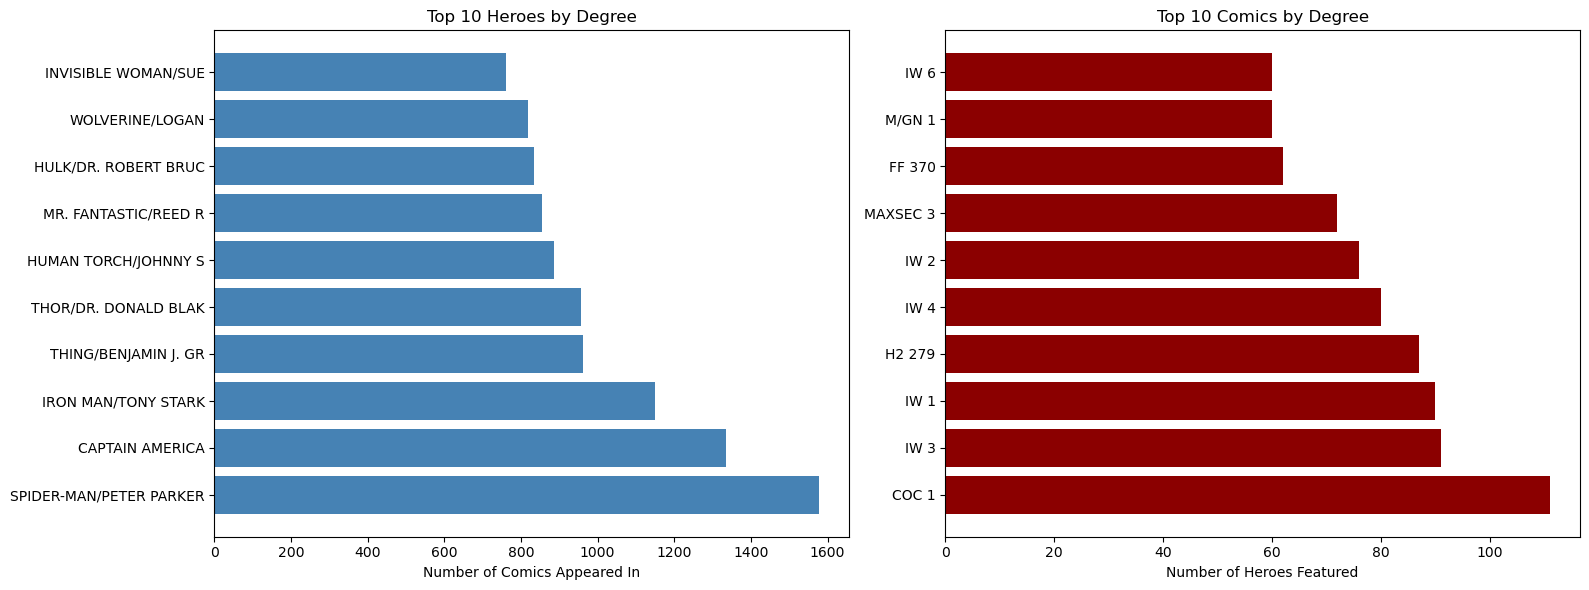

In [12]:
# Get degrees for all nodes
degrees = dict(B.degree())

# Separate degrees by type
comic_degrees = {n: deg for n, deg in degrees.items() if B.nodes[n].get('bipartite') == 0}
hero_degrees = {n: deg for n, deg in degrees.items() if B.nodes[n].get('bipartite') == 1}

# Get top 10 by degree
top_10_comics = sorted(comic_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_heroes = sorted(hero_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heroes
axes[0].barh(
    [name for name, _ in reversed(top_10_heroes)],
    [deg for _, deg in reversed(top_10_heroes)],
    color='steelblue'
)
axes[0].set_title('Top 10 Heroes by Degree')
axes[0].set_xlabel('Number of Comics Appeared In')
axes[0].invert_yaxis()

# Comics
axes[1].barh(
    [name for name, _ in reversed(top_10_comics)],
    [deg for _, deg in reversed(top_10_comics)],
    color='darkred'
)
axes[1].set_title('Top 10 Comics by Degree')
axes[1].set_xlabel('Number of Heroes Featured')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


### 4.1.2 Centrality  
We do those analysis on a subgraph composed of the 6 different Infinity War (IW) comics and the heroes that appear in them.

#### 4.1.2.1 Subgraph Creation and Vizualisation

In [13]:
# Define the Infinity Saga comics nodes
infinity_war_comics = [ 
                       "TQ 1", "TQ 2", 
                       "IG 1", "IG 2", "IG 3", "IG 4", "IG 5", "IG 6",
                       "IW 1", "IW 2", "IW 3", "IW 4", "IW 5", "IW 6",
                       "WIW 1", "WIW 2", "WIW 3", "WIW 4", "WIW 5", "WIW 6", "WIW 7", "WIW 8", "WIW 9", "WIW 10", "WIW 11",
                       ]

# Find which of these comics actually exist in the graph
existing_iw_comics = set(infinity_war_comics) & set(B.nodes())
if len(existing_iw_comics) < len(infinity_war_comics):
    print(f"Warning: Only {len(existing_iw_comics)} out of {len(infinity_war_comics)} Infinity War comics found in the graph.")
    print("Comics found:", existing_iw_comics)

# Find all heroes connected to these comics
connected_heroes = set()
for comic in existing_iw_comics:
    # Check if the node exists in the graph before getting neighbors
    if comic in B:
        # Get heroes connected to this comic
        heroes = {n for n in B.neighbors(comic) if B.nodes[n].get('bipartite') == 1}
        connected_heroes.update(heroes)

# Create subgraph with Infinity War comics + connected heroes
selected_nodes = existing_iw_comics | connected_heroes
iw_subgraph = B.subgraph(selected_nodes) #the new subgraph

# Count node types in subgraph
comics_subgraph = {n for n in iw_subgraph if iw_subgraph.nodes[n].get('bipartite') == 0}
heroes_subgraph = {n for n in iw_subgraph if iw_subgraph.nodes[n].get('bipartite') == 1}

# Quick stats
print("\nInfinity War Subgraph Summary:")
print(f"Number of nodes in Subgraph: {iw_subgraph.number_of_nodes()}")
print(f" - Comics: {len(comics_subgraph)}")
print(f" - Heroes: {len(heroes_subgraph)}")
print(f"Number of edges in Subgraph: {iw_subgraph.number_of_edges()}")


Infinity War Subgraph Summary:
Number of nodes in Subgraph: 218
 - Comics: 25
 - Heroes: 193
Number of edges in Subgraph: 789


In [ ]:
# define your series and a color palette
infinity_war_comics = [ 
    "TQ 1","TQ 2",
    "IG 1","IG 2","IG 3","IG 4","IG 5","IG 6",
    "IW 1","IW 2","IW 3","IW 4","IW 5","IW 6",
    "WIW 1","WIW 2","WIW 3","WIW 4","WIW 5","WIW 6","WIW 7","WIW 8","WIW 9","WIW 10","WIW 11",
]
# extract unique prefixes
series = sorted({c.split()[0] for c in infinity_war_comics})
# assign each a distinct color
palette = ['#e6194b','#3cb44b','#ffe119','#4363d8']  # one per series
series_colors = dict(zip(series, palette))

# default colors
default_comic_color  = '#000000'
default_hero_color = '#888888' # grey
thanos_color        = '#f032e6'  # pink

# annotate nodes
for n in iw_subgraph.nodes():
    if iw_subgraph.nodes[n].get('bipartite') == 1:
        # hero
        iw_subgraph.nodes[n]['color'] = thanos_color if n == 'THANOS' else default_hero_color
        iw_subgraph.nodes[n]['size']  = iw_subgraph.degree(n)
        iw_subgraph.nodes[n]['label'] = n
    else:
        # comic
        prefix = n.split()[0]
        iw_subgraph.nodes[n]['color'] = series_colors.get(prefix, default_comic_color)
        iw_subgraph.nodes[n]['size']  = B.degree(n)
        iw_subgraph.nodes[n]['label'] = ''  # hide comic labels

# print mapping
print("Series → color mapping:")
print( 'IG is green')
print( 'IW is yellow')
print( 'WIW is blue')
print( 'TQ is red')
print(f"\nHero THANOS: orange")
print(f"Other heroes: pink")

# render
gv.three(
    data=iw_subgraph,
    graph_height=600,
    node_size_data_source='size',
    use_node_size_normalization=True,
    node_size_normalization_min=5,
    node_size_normalization_max=50,
    node_hover_tooltip=True,
    show_node_label=False, #change to True to show labels
    # node_label_data_source='label', #uncomment to show labels
    layout_algorithm_active=True,
    use_many_body_force=True,
    many_body_force_strength=-100,
    use_links_force=True,
    links_force_distance=40,
    links_force_strength=0.4,
)

Series → color mapping:
IG is green
IW is yellow
WIW is blue
TQ is red

Hero THANOS: orange
Other heroes: pink


Hero THANOS appears in all series.


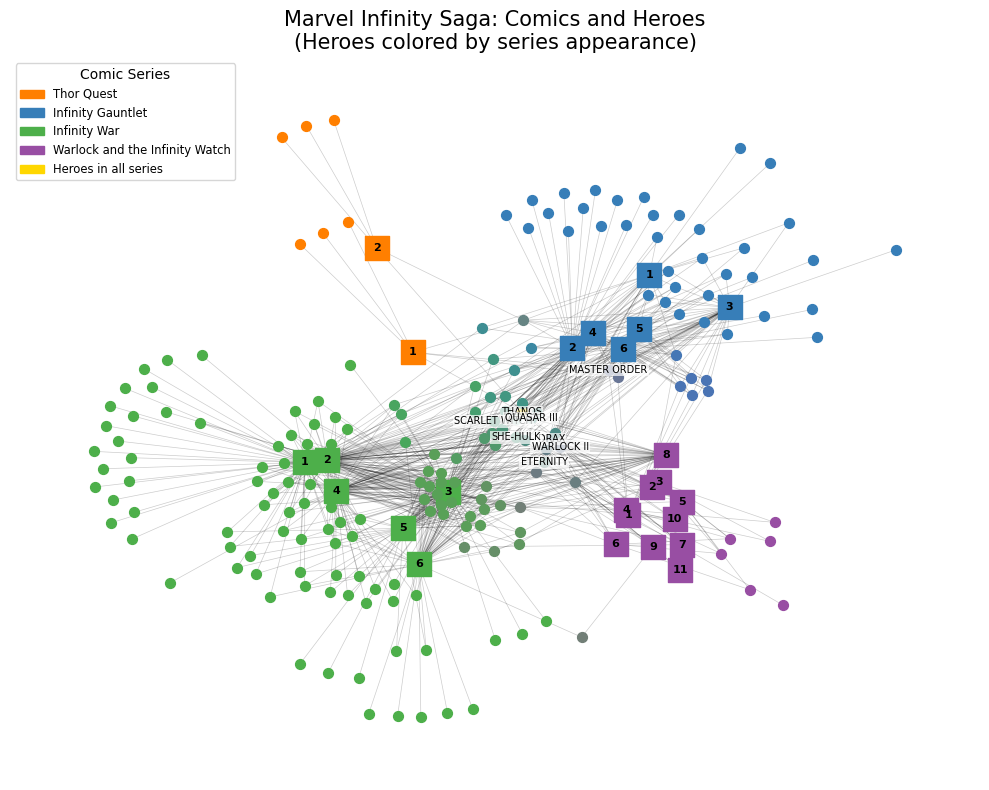

In [19]:
# Define the series groups and their colors
series_colors = {
    'TQ': '#ff7f00',  # Orange for Thor Quest
    'IG': '#377eb8',  # Blue for Infinity Gauntlet
    'IW': '#4daf4a',  # Green for Infinity War
    'WIW': '#984ea3'  # Purple for Warlock and the Infinity Watch
}

# Function to determine which series a comic belongs to
def get_comic_series(comic_name):
    if comic_name.startswith('TQ '):
        return 'TQ'
    elif comic_name.startswith('IG '):
        return 'IG'
    elif comic_name.startswith('IW ') or comic_name == 'IW':
        return 'IW'
    elif comic_name.startswith('WIW '):
        return 'WIW'
    return None

# Extract comics and heroes from subgraph
comics_subgraph = [node for node in iw_subgraph.nodes() if any(node.startswith(prefix) for prefix in ['TQ ', 'IG ', 'IW ', 'WIW ']) or node == 'IW']
heroes_subgraph = [node for node in iw_subgraph.nodes() if node not in comics_subgraph]

# Visualize subgraph
plt.figure(figsize=(10, 8))

# We'll create a custom layout to organize comics by series
pos = {}

# First place comic groups in specific areas
series_positions = {
    'TQ': (-1, 1),   # Thor Quest in top left
    'IG': (1, 1),    # Infinity Gauntlet in top right
    'IW': (-1, -1),  # Infinity War in bottom left
    'WIW': (1, -1)   # Warlock and Infinity Watch in bottom right
}

# Position comics by series
for comic in comics_subgraph:
    series = get_comic_series(comic)
    if series:
        base_x, base_y = series_positions[series]
        # Add some jitter within the series cluster
        jitter = 0.6
        pos[comic] = (base_x + np.random.uniform(-jitter, jitter), 
                      base_y + np.random.uniform(-jitter, jitter))

# Place heroes based on their connections
for hero in heroes_subgraph:
    connected_comics = [comic for comic in comics_subgraph if iw_subgraph.has_edge(hero, comic)]
    if connected_comics:
        # Average the positions of connected comics
        x = np.mean([pos[comic][0] for comic in connected_comics if comic in pos])
        y = np.mean([pos[comic][1] for comic in connected_comics if comic in pos])
        # Add some random jitter to prevent overlaps
        jitter = 0.4
        pos[hero] = (x + np.random.uniform(-jitter, jitter), 
                     y + np.random.uniform(-jitter, jitter))

# Refine positions with force-directed layout, but keep comics fixed
fixed_nodes = comics_subgraph
fixed_positions = {node: pos[node] for node in fixed_nodes if node in pos}
pos = nx.spring_layout(iw_subgraph, pos=pos, fixed=fixed_nodes, k=0.3, seed=42, iterations=50)

# Group comics by series for coloring
series_comics = {series: [] for series in series_colors}
for comic in comics_subgraph:
    series = get_comic_series(comic)
    if series:
        series_comics[series].append(comic)

# Draw comic nodes with colors based on series
for series, comics_list in series_comics.items():
    if comics_list:
        nx.draw_networkx_nodes(iw_subgraph, pos, nodelist=comics_list, 
                              node_color=series_colors[series], node_shape='s', node_size=300)

# Find which series each hero appears in
hero_series = {}
for hero in heroes_subgraph:
    series_appearances = {series: 0 for series in series_colors}
    
    # Count appearances in each series
    for comic in comics_subgraph:
        if iw_subgraph.has_edge(hero, comic):
            series = get_comic_series(comic)
            if series:
                series_appearances[series] += 1
    
    hero_series[hero] = series_appearances

# Calculate hero colors based on which series they appear in
hero_colors = {}
for hero, series_appearances in hero_series.items():
    # Calculate total appearances
    total_appearances = sum(series_appearances.values())
    
    if total_appearances == 0:
        hero_colors[hero] = 'gray'  # Default color if no appearances
        continue
        
    # If hero appears in only one series, use that color
    appearing_in = [s for s, count in series_appearances.items() if count > 0]
    if len(appearing_in) == 1:
        hero_colors[hero] = series_colors[appearing_in[0]]
    else:
        # For heroes in multiple series, blend colors based on proportion
        r, g, b = 0, 0, 0
        for series, count in series_appearances.items():
            if count > 0:
                weight = count / total_appearances
                color = colors.to_rgb(series_colors[series])
                r += color[0] * weight
                g += color[1] * weight
                b += color[2] * weight
        hero_colors[hero] = (r, g, b)
        
    # Special case: heroes appearing in all series get gold
    if all(count > 0 for count in series_appearances.values()):
        hero_colors[hero] = 'gold'

# Draw hero nodes with their calculated colors
for hero in heroes_subgraph:
    if hero in pos:  # Make sure hero is in our layout
        nx.draw_networkx_nodes(iw_subgraph, pos, nodelist=[hero], 
                              node_color=[hero_colors[hero]], node_size=50)

# Draw edges with transparency
nx.draw_networkx_edges(iw_subgraph, pos, alpha=0.2, width=0.5)

# Create labels for comics (shortened for readability)
comic_labels = {}
for comic in comics_subgraph:
    if comic in pos:  # Make sure comic is in our layout
        series = get_comic_series(comic)
        if series:
            short_name = comic.replace(series, "").strip()
            comic_labels[comic] = short_name
        else:
            comic_labels[comic] = comic

# Draw labels for comics
nx.draw_networkx_labels(iw_subgraph, pos, labels=comic_labels, 
                       font_size=8, font_weight='bold')

# Find heroes that appear in multiple series
heroes_in_multiple_series = []
for hero, series_appearances in hero_series.items():
    # Count how many series this hero appears in
    series_count = sum(1 for count in series_appearances.values() if count > 0)
    if series_count > 1:
        heroes_in_multiple_series.append((hero, series_count))

# Sort heroes by number of series they appear in
heroes_in_multiple_series.sort(key=lambda x: x[1], reverse=True)

# Limit to a reasonable number of labels for heroes
important_heroes = [hero for hero, _ in heroes_in_multiple_series[:8]]

# Create labels for important heroes
hero_labels = {}
for hero in important_heroes:
    if hero in pos:  # Make sure hero is in our layout
        # Shorten hero name for readability
        short_name = hero.split('/')[0] if '/' in hero else hero
        hero_labels[hero] = short_name

# Draw labels for important heroes
nx.draw_networkx_labels(iw_subgraph, pos, labels=hero_labels, 
                       font_size=7, font_color='black',
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Create legend for series
legend_elements = []
for series, color in series_colors.items():
    series_names = {
        'TQ': 'Thor Quest',
        'IG': 'Infinity Gauntlet',
        'IW': 'Infinity War',
        'WIW': 'Warlock and the Infinity Watch'
    }
    legend_elements.append(
        mpatches.Patch(color=color, label=series_names[series])
    )

# Add a special entry for heroes in all series (if any)
heroes_in_all_series = []
for hero, series_appearances in hero_series.items():
    if all(count > 0 for count in series_appearances.values()):
        print(f"Hero {hero} appears in all series.")
        heroes_in_all_series.append(hero)

if heroes_in_all_series:
    legend_elements.append(
        mpatches.Patch(color='gold', label="Heroes in all series")
    )

# Add legend
plt.legend(handles=legend_elements, loc='upper left', 
          title="Comic Series", fontsize='small')

# Add a title
plt.title("Marvel Infinity Saga: Comics and Heroes\n(Heroes colored by series appearance)", fontsize=15)

plt.axis('off')
plt.tight_layout()
plt.show()

# If you want to save the figure
# plt.savefig('infinity_saga_network.png', dpi=300, bbox_inches='tight')

In [20]:
# Find the diameter of the subgraph (maximum shortest path length)
try:
    diameter = nx.diameter(iw_subgraph)
    print(f"Diameter of the graph: {diameter}")
except nx.NetworkXError:
    print("Graph is not connected, cannot compute diameter")

# Compute eccentricity (maximum distance from each node to any other node)
try:
    eccentricity = nx.eccentricity(iw_subgraph)
    
    # Find the center of the graph (nodes with minimum eccentricity)
    center = nx.center(iw_subgraph)
    center_comics = [node for node in center if node in comics_subgraph]
    center_heroes = [node for node in center if node in heroes_subgraph]
    
    print(f"Center comics: {center_comics}")
    print(f"Center heroes: {center_heroes[:10]}")
    
    # Find peripheral nodes (nodes with maximum eccentricity)
    periphery = nx.periphery(iw_subgraph)
    print(f"Number of peripheral nodes: {len(periphery)}")
except nx.NetworkXError:
    print("Graph is not connected, cannot compute eccentricity")

Diameter of the graph: 6
Center comics: ['IG 3', 'IG 4', 'IW 3', 'IW 4', 'IW 5', 'IW 1', 'IG 5', 'IW 6']
Center heroes: []
Number of peripheral nodes: 12


#### 4.1.2.1 Betweenness Centrality

In [21]:
# Compute betweenness centrality on the subgraph
betweenness = nx.betweenness_centrality(iw_subgraph)

# Separate by type
comic_betweenness = {n: c for n, c in betweenness.items() if iw_subgraph.nodes[n].get('bipartite') == 0}
hero_betweenness = {n: c for n, c in betweenness.items() if iw_subgraph.nodes[n].get('bipartite') == 1}

# Top most central comic
top_comics = sorted(comic_betweenness.items(), key=lambda x: x[1], reverse=True)[:6]



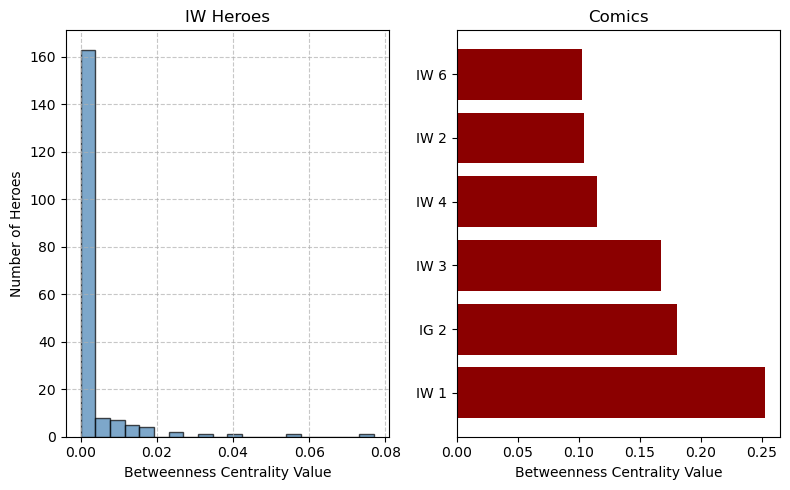

In [22]:
#Visualisation of Betweenness Centrality
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Heroes
centrality_values = list(hero_betweenness.values())
axes[0].hist(centrality_values, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_title('IW Heroes')
axes[0].set_xlabel('Betweenness Centrality Value')
axes[0].set_ylabel('Number of Heroes')
axes[0].grid(True, linestyle='--', alpha=0.7)


# Comics
axes[1].barh(
    [n for n, _ in reversed(top_comics)],
    [c for _, c in reversed(top_comics)],
    color='darkred'
)
axes[1].set_title('Comics')
axes[1].set_xlabel('Betweenness Centrality Value')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


#### 4.1.2.3. Closeness Centrality

In [23]:
# Compute closeness centrality on the subgraph
closeness = nx.closeness_centrality(iw_subgraph)

# Separate by type
comic_closeness = {n: c for n, c in closeness.items() if iw_subgraph.nodes[n].get('bipartite') == 0}
hero_closeness = {n: c for n, c in closeness.items() if iw_subgraph.nodes[n].get('bipartite') == 1}

# Get top most central comics by closeness
top_comics_by_closeness = sorted(comic_closeness.items(), key=lambda x: x[1], reverse=True)[:10]

# Get top most central heroes by closeness
top_heroes_by_closeness = sorted(hero_closeness.items(), key=lambda x: x[1], reverse=True)[:10]

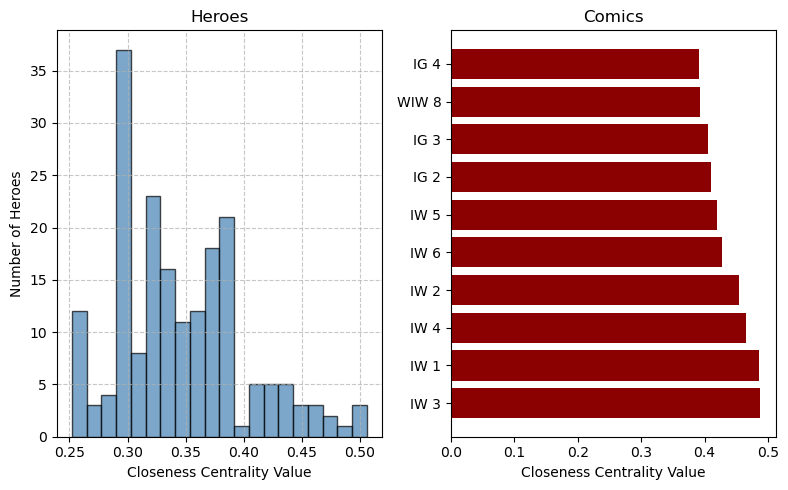

In [24]:
#Visualisation of Closeness Centrality
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Heroes
closeness_values = list(hero_closeness.values())
axes[0].hist(closeness_values, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_title('Heroes')
axes[0].set_xlabel('Closeness Centrality Value')
axes[0].set_ylabel('Number of Heroes')
axes[0].grid(True, linestyle='--', alpha=0.7)


# Comics
axes[1].barh(
    [n for n, _ in reversed(top_comics_by_closeness)],
    [c for _, c in reversed(top_comics_by_closeness)],
    color='darkred'
)
axes[1].set_title('Comics')
axes[1].set_xlabel('Closeness Centrality Value')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### 4.1.3 Cosine Similarity

In [25]:
# Step 1: Get comics and heroes from your subgraph
# You've already identified these in your code
comics = {n for n in iw_subgraph if iw_subgraph.nodes[n].get('bipartite') == 0}
heroes = {n for n in iw_subgraph if iw_subgraph.nodes[n].get('bipartite') == 1}

# Convert sets to lists for indexing
comics_list = list(comics)
heroes_list = list(heroes)

# Step 2: Create biadjacency matrix
# Initialize empty matrix of right size
biadj_matrix = np.zeros((len(comics_list), len(heroes_list)))

# Fill the matrix with edge data
for i, comic in enumerate(comics_list):
    for j, hero in enumerate(heroes_list):
        if iw_subgraph.has_edge(comic, hero):
            biadj_matrix[i, j] = 1

# Step 3: Calculate cosine similarities
# Comics similarity - based on which heroes appear in each comic
comics_similarity = cosine_similarity(biadj_matrix)

# Heroes similarity - based on which comics each hero appears in
heroes_similarity = cosine_similarity(biadj_matrix.T)

# Step 4: Create dictionaries for easy lookup of similarity scores
comics_similarity_dict = {}
for i, comic1 in enumerate(comics_list):
    comics_similarity_dict[comic1] = {}
    for j, comic2 in enumerate(comics_list):
        if i != j:  # Skip self-similarity
            comics_similarity_dict[comic1][comic2] = comics_similarity[i, j]

heroes_similarity_dict = {}
for i, hero1 in enumerate(heroes_list):
    heroes_similarity_dict[hero1] = {}
    for j, hero2 in enumerate(heroes_list):
        if i != j:  # Skip self-similarity
            heroes_similarity_dict[hero1][hero2] = heroes_similarity[i, j]

# Step 5: Example functions to access the results

def most_similar_comics(comic_name, top_n=5):
    """Find the most similar comics to the given comic"""
    if comic_name not in comics_similarity_dict:
        return "Comic not found in the subgraph"
    
    similar_comics = sorted(comics_similarity_dict[comic_name].items(), 
                           key=lambda x: x[1], reverse=True)
    return similar_comics[:top_n]

def most_similar_heroes(hero_name, top_n=3):
    """Find the most similar heroes to the given hero"""
    if hero_name not in heroes_similarity_dict:
        return "Hero not found in the subgraph"
    
    similar_heroes = sorted(heroes_similarity_dict[hero_name].items(), 
                           key=lambda x: x[1], reverse=True)
    return similar_heroes[:top_n]

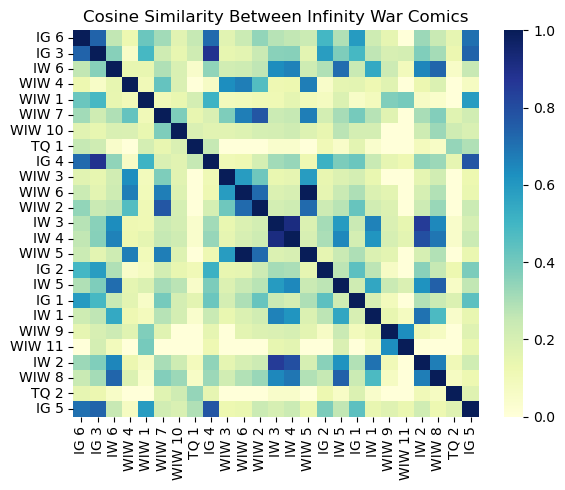

In [26]:
# Visualize it in a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(comics_similarity, annot=False, cmap="YlGnBu", 
            xticklabels=comics_list, yticklabels=comics_list)
plt.title("Cosine Similarity Between Infinity War Comics")
plt.tight_layout()
plt.savefig("comics_similarity_heatmap.png")
plt.show()

## 4.2 Hero-Hero Projection (not mentionned in the report)

In [91]:
# Identify bipartite sets from the original graph
heroes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}

# Create projections where the edges are weighted by the number of common comics
hero_hero_proj = bipartite.weighted_projected_graph(B, heroes)

# Quick stats
print(f"Hero–Hero projection: {hero_hero_proj.number_of_nodes()} nodes, {hero_hero_proj.number_of_edges()} edges")


Hero–Hero projection: 6439 nodes, 171669 edges


### 4.2.1 Graph Exploration

In [92]:
projection = hero_hero_proj

# 1. Compute basic metrics
degree_dict = dict(projection.degree())
strength_dict = dict(projection.degree(weight='weight'))
betweenness_dict = nx.betweenness_centrality(projection, weight='weight')
closeness_dict = nx.closeness_centrality(projection)
eigenvector_dict = nx.eigenvector_centrality(projection, weight='weight')
clustering_dict = nx.clustering(projection, weight='weight')

# 2. Community detection (assign each node a community label)
communities = greedy_modularity_communities(projection)
community_dict = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_dict[node] = i

# 3. Create the DataFrame
hero_stats_df = pd.DataFrame({
    'Degree': pd.Series(degree_dict),
    'Strength': pd.Series(strength_dict),
    'Betweenness': pd.Series(betweenness_dict),
    'Closeness': pd.Series(closeness_dict),
    'Eigenvector': pd.Series(eigenvector_dict),
    'Clustering Coef': pd.Series(clustering_dict),
    'Community': pd.Series(community_dict)
})

# Display top 10 by eigenvector centrality, for example
hero_stats_df.sort_values('Eigenvector', ascending=False).head(10)


KeyboardInterrupt: 

### 4.2.2 Isolated nodes

In [22]:
# Get all isolated nodes (nodes with degree 0)
isolated_nodes = list(nx.isolates(hero_hero_proj))

# Show counts and optionally the actual names
print(f"Number of isolated heroes: {len(isolated_nodes)}")

# See their names
print("Isolated heroes:", isolated_nodes)

Number of isolated heroes: 18
Isolated heroes: ['LUNATIK II', 'GERVASE, LADY ALYSSA', 'CLUMSY FOULUP', 'RUNE', 'ZANTOR', 'BLARE/', 'GIURESCU, RADU', 'RANDAK', 'SEA LEOPARD', 'JOHNSON, LYNDON BAIN', 'CALLAHAN, DANNY', 'KULL', 'DEATHCHARGE', 'FENRIS', 'MARVEL BOY II/MARTIN', 'RED WOLF II', 'BERSERKER II', 'SHARKSKIN']


### 4.2.3 Visualisations
We will now visualise a sub-graph of the hero-hero projection. The subgraph is composed of the top 10 nodes with the highest degree value.

In [39]:
# Top 20 heroes by degree
top_heroes = sorted(hero_hero_proj.degree, key=lambda x: x[1], reverse=True)[:10]
top_hero_nodes = [node for node, _ in top_heroes]
H_subgraph = hero_hero_proj.subgraph(top_hero_nodes)


**Heatmap of adjacency matrix**  
Since we have a weighted graph, we can visualise the edges weights between the top 10 heroes as a matrix.

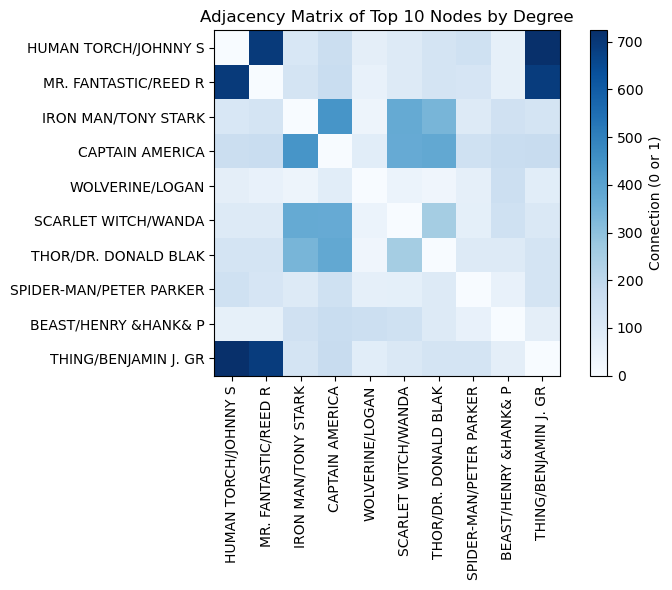

In [ ]:
# Compute degrees and sort them (highest to lowest)
degrees = dict(H_subgraph.degree())
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Select the top 10 nodes based on degree
top_10_nodes = [node for node, _ in sorted_nodes[:10]]

# Create subgraph of just those top 10 nodes
top10_subgraph = H_subgraph.subgraph(top_10_nodes)

# Create the adjacency matrix as a DataFrame (for better labeling)
adj_matrix = nx.to_pandas_adjacency(top10_subgraph, nodelist=top_10_nodes)

# Plot the adjacency matrix
plt.figure(figsize=(8, 6))
plt.imshow(adj_matrix, cmap='Blues', interpolation='none')

# Set axis ticks and labels
plt.xticks(ticks=range(len(top_10_nodes)), labels=top_10_nodes, rotation=90)
plt.yticks(ticks=range(len(top_10_nodes)), labels=top_10_nodes)

# Add grid and title
plt.grid(False)
plt.title("Adjacency Matrix of Top 10 Nodes by Degree")

# Show color bar
plt.colorbar(label='Connection (0 or 1)')

plt.tight_layout()
plt.show()


- HUMAN TORCH/JOHNNY S has a very dark cell with THING/BENJAMIN J. GR:→ This means they collaborated or co-appeared very frequently (strong connection).
- IRON MAN/TONY STARK and CAPTAIN AMERICA also have a darker cell between them: → They’re often linked (e.g., both Avengers).
- If a row/column is mostly light (e.g., WOLVERINE/LOGAN), it means that node has fewer or weaker connections with others in the top 10.

### 4.2.4 Community Detection  
Using Greedy Modularity

In [58]:
# Using the Greedy Modularity (fast and good for large graphs)
communities = list(greedy_modularity_communities(hero_hero_proj))
print(f"Detected {len(communities)} communities")

# Build a summary graph of communities:
summary_graph = nx.Graph()
for i, com in enumerate(communities):
    summary_graph.add_node(i, size=len(com))



Detected 117 communities


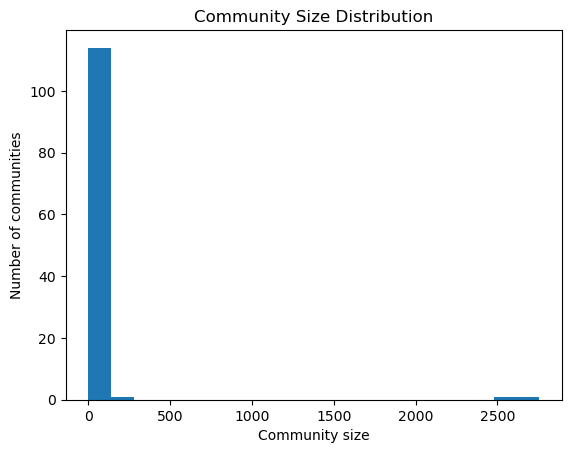

In [43]:
# Community size distribution
community_sizes = [len(c) for c in communities]
plt.hist(community_sizes, bins=20)
plt.title("Community Size Distribution")
plt.xlabel("Community size")
plt.ylabel("Number of communities")
plt.show()


In [44]:
# Top heroes in each community
for i, community in enumerate(communities[:5]):
    print(f"\nCommunity {i + 1} — {len(community)} heroes")
    degrees = hero_hero_proj.subgraph(community).degree()
    top_heroes = sorted(degrees, key=lambda x: x[1], reverse=True)[:5]
    for hero, deg in top_heroes:
        print(f"  {hero} (degree: {deg})")



Community 1 — 2756 heroes
  SPIDER-MAN/PETER PARKER (degree: 1005)
  WOLVERINE/LOGAN (degree: 799)
  BEAST/HENRY &HANK& P (degree: 679)
  MARVEL GIRL/JEAN GRE (degree: 676)
  STORM/ORORO MUNROE S (degree: 675)

Community 2 — 2511 heroes
  CAPTAIN AMERICA (degree: 1344)
  IRON MAN/TONY STARK (degree: 1135)
  SCARLET WITCH/WANDA (degree: 1009)
  VISION (degree: 987)
  THOR/DR. DONALD BLAK (degree: 970)

Community 3 — 171 heroes
  MERRYWEATHER, IRENE (degree: 65)
  BLACK FOX/ROBERT W. (degree: 52)
  PIXIE/ [ETERNAL] (degree: 51)
  EFFIGY/LT. VELMAX/JA (degree: 50)
  MR. JUSTICE/TIMOTHY (degree: 47)

Community 4 — 117 heroes
  BRUTE | MUTANT X-VER (degree: 115)
  BLOODSTORM | MUTANT (degree: 115)
  ICE-MAN | MUTANT X-V (degree: 114)
  SUMMERS, SCOTT III | (degree: 93)
  MAGNETO | MUTANT X-V (degree: 85)

Community 5 — 69 heroes
  RADIUS/JARED CORBO (degree: 47)
  MURMUR II/ARLETTE TR (degree: 47)
  FLEX/ADRIAN CORBO (degree: 44)
  GUARDIAN V/JAMES MAC (degree: 44)
  MANBOT/BERNIE LACHEN (

## 4.3 Comic-Comic Projection (not mentionned in the report)

In [59]:
# Identify bipartite sets from the original graph
comics = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}

# Create projection where the edges are weighted by the number of common heroes
comic_comic_proj = bipartite.weighted_projected_graph(B, comics)

# Quick stats
print(f"Comic–Comic projection: {comic_comic_proj.number_of_nodes()} nodes, {comic_comic_proj.number_of_edges()} edges")

Comic–Comic projection: 12651 nodes, 7022085 edges


In [60]:
projection = comic_comic_proj

# 1. Compute basic metrics
degree_dict = dict(projection.degree())
strength_dict = dict(projection.degree(weight='weight'))
betweenness_dict = nx.betweenness_centrality(projection, weight='weight')
closeness_dict = nx.closeness_centrality(projection)
eigenvector_dict = nx.eigenvector_centrality(projection, weight='weight')
clustering_dict = nx.clustering(projection, weight='weight')

# 2. Community detection (assign each node a community label)
communities = greedy_modularity_communities(projection)
community_dict = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_dict[node] = i

# 3. Create the DataFrame
comic_stats_df = pd.DataFrame({
    'Degree': pd.Series(degree_dict),
    'Strength': pd.Series(strength_dict),
    'Betweenness': pd.Series(betweenness_dict),
    'Closeness': pd.Series(closeness_dict),
    'Eigenvector': pd.Series(eigenvector_dict),
    'Clustering Coef': pd.Series(clustering_dict),
    'Community': pd.Series(community_dict)
})

# Display top 10 by eigenvector centrality, for example
comic_stats_df.sort_values('Eigenvector', ascending=False).head(10)

KeyboardInterrupt: 

# 5. Network Analysis

## 5.1 Collaborative Filtering

In [27]:
def predict_unseen_comics(hero_name, hero_comic_matrix, method, k=None):
    """
    Predict comics a hero hasn't appeared in using collaborative filtering
    
    Parameters:
    -----------
    hero_name : str
        Name of the hero to make predictions for
    hero_comic_matrix : pd.DataFrame
        Binary matrix where rows are heroes and columns are comics
    k : int
        Number of neighbors to consider
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with comics and scores, sorted by score
    """
    # Convert to numpy arrays
    value_matrix = hero_comic_matrix.values
    heroes = hero_comic_matrix.index.tolist()
    comics = hero_comic_matrix.columns.tolist()
    
    # Get the index of the target hero
    try:
        id = heroes.index(hero_name)
    except ValueError:
        print(f"Hero {hero_name} not found in the dataset")
        return pd.DataFrame(columns=['comic', 'score'])
    
    # Get the interaction vector for the target hero
    active_vector = value_matrix[id:id+1]
    
    if method == 'cosine':
        similarities = cosine_similarity(active_vector, value_matrix).flatten()
    elif method == 'pearson':
        t = hero_comic_matrix.T
        similarities = t.corr(method='pearson')[hero_name]
    
    neighbor_indices = similarities.argsort()[::-1]

    if k is not None:
        neighbor_indices = neighbor_indices[1:k+1]
        neighbor_weights = similarities[neighbor_indices]
        neighbor_vectors = value_matrix[neighbor_indices]
        weighted_sum = np.dot(neighbor_weights, neighbor_vectors)
        weighted_absolute_sum = np.sum(np.abs(weighted_sum))
    else: 
        neighbor_weights = similarities[neighbor_indices][1:]
        neighbor_vectors = value_matrix[neighbor_indices][1:]
        weighted_sum = np.dot(neighbor_weights, neighbor_vectors)
        weighted_absolute_sum = np.sum(np.abs(weighted_sum))
    
    # # Display top neighbors
    # print(f"Top {k} neighbors for {hero_name}:")
    # for i, idx in enumerate(neighbor_indices):
    #     print(f"  {i+1}. {heroes[idx]} (similarity: {similarities[idx]:.4f})")
    
    # Only predict for comics the hero hasn't appeared in
    comics_mask = active_vector.flatten() == 0
    # Calculated the sum of the absolute values of the weights
    predicted_scores = (weighted_sum * comics_mask)/weighted_absolute_sum
    
    # Create and sort result dataframe
    score_df = pd.DataFrame({
        'comic': comics,
        'score': predicted_scores
    }).sort_values('score', ascending=False)
    
    # Remove comics with score <= 0
    score_df = score_df[score_df['score'] > 0]

    
    return score_df

In [28]:
# test with a hero

hero_comic_matrix = (edges_df
    .assign(val=1)
    .pivot_table(index='hero', columns='comic', values='val', fill_value=0)
)
df = predict_unseen_comics('THANOS', hero_comic_matrix, 'cosine', k=10)
df

,comic,score
11791,WLOCK2 1,0.010888
11793,WLOCK2 3,0.010888
11768,WIW 2,0.010856
11771,WIW 5,0.010856
11772,WIW 6,0.010856
...,...,...
9346,SOLOA 20/2,0.001277
3149,DEF 78,0.001277
6,A '99,0.001277
94,A 177,0.001277


## 5.2 Evaluation Pipeline

In [32]:
def load_edge_list(path):
    """
    Load edges from a CSV or text file with 'hero,comic' columns or whitespace-separated.
    Returns a list of (hero, comic) tuples.
    """
    try:
        df = pd.read_csv(path)
        edges = list(zip(df.iloc[:, 0], df.iloc[:, 1]))
    except Exception:
        edges = []
        with open(path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    edges.append((parts[0], parts[1]))
    return edges


def sample_edges(edges, num_edges):
    """
    Uniformly sample a subset of edges, preserving connectivity heuristics.
    """
    if num_edges >= len(edges):
        return edges.copy()
    return random.sample(edges, num_edges)


def build_matrix(edges):
    """
    Build hero-comic sparse binary matrix and mappings.
    Returns: matrix (n_heroes x n_comics), heroes list, comics list
    """
    heroes = sorted({h for h, c in edges})
    comics = sorted({c for h, c in edges})
    h2i = {h: i for i, h in enumerate(heroes)}
    c2i = {c: i for i, c in enumerate(comics)}
    row_inds = [h2i[h] for h, c in edges]
    col_inds = [c2i[c] for h, c in edges]
    data = np.ones(len(edges), dtype=np.int8)
    mat = sp.csr_matrix((data, (row_inds, col_inds)), shape=(len(heroes), len(comics)))
    return mat, heroes, comics


def sample_test_tasks(edges, num_tasks=500):
    """
    Select heroes with at least one edge, hold out one comic per hero.
    Returns list of (hero, heldout_comic, remaining_edges)
    """
    # Group edges by hero
    by_hero = {}
    for h, c in edges:
        by_hero.setdefault(h, []).append(c)
    candidates = [h for h, clist in by_hero.items() if len(clist) > 1]
    chosen = random.sample(candidates, min(num_tasks, len(candidates)))
    tasks = []
    for h in chosen:
        clist = by_hero[h]
        held = random.choice(clist)
        remaining = [(h2, c2) for (h2, c2) in edges if not (h2 == h and c2 == held)]
        tasks.append((h, held, remaining))
    return tasks


def find_rank(score_df, heldout):
    """
    Find 1-based rank of the heldout comic in score_df, or len+1 if missing.
    """
    ranks = score_df.reset_index(drop=True)
    matches = ranks[ranks['comic'] == heldout]
    if matches.empty:
        return len(ranks) + 1
    return matches.index[0] + 1


def predict_unseen_comics(hero_name, mat, heroes, comics, method, k=None):
    """
    Collaborative filtering predict as provided.
    mat: sparse CSR matrix, heroes x comics
    """
    # convert to dense row for target
    if hero_name not in heroes:
        return pd.DataFrame(columns=['comic','score'])
    
    idx = heroes.index(hero_name)
    active = mat[idx:idx+1].toarray()  # 1 x C

    # compute similarity
    if method == 'cosine':
        sim = cosine_similarity(active, mat.toarray()).flatten()
    elif method == 'pearson':
        df = pd.DataFrame(mat.toarray(), index=heroes, columns=comics)
        sim = df.T.corr(method='pearson')[hero_name].values
    else:
        raise ValueError("Unknown method")

    # sort and optionally select k neighbors (excluding self)
    order = np.argsort(sim)[::-1]
    if k:
        neighbors = order[1:k+1]
        weights = sim[neighbors]
        vecs = mat[neighbors].toarray()
    else:
        neighbors = order[1:]
        weights = sim[neighbors]
        vecs = mat[neighbors].toarray()
    weighted_sum = weights.dot(vecs)

    # normalize by sum of absolute weights
    norm = np.sum(np.abs(weights))
    pred = (weighted_sum / norm) * (active.flatten() == 0)
    df_out = pd.DataFrame({'comic': comics, 'score': pred})
    df_out = df_out[df_out['score'] > 0].sort_values('score', ascending=False)
    return df_out


def evaluate(edges, fractions, methods, ks, num_tasks, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    results = []
    for f in fractions:
        print(f"Sampling {f} edges...")
        sub_edges = sample_edges(edges, f)
        mat, heroes, comics = build_matrix(sub_edges)
        tasks = sample_test_tasks(sub_edges, num_tasks)
        for method in methods:
            for k in ks:
                print(f"Evaluating {method}, k={k}, fraction={f}")
                # sim time
                t0 = time.perf_counter()
                # for Pearson, we precompute via DataFrame inside predict
                # for Cosine, nothing to precompute here
                _ = None
                t_sim = time.perf_counter() - t0

                # prediction loop
                t1 = time.perf_counter()
                ranks = []
                for h, held, rem_edges in tasks:
                    # rebuild matrix for this hero's holdout
                    df_mat, df_heroes, df_comics = build_matrix(rem_edges)
                    df_scores = predict_unseen_comics(h, df_mat, df_heroes, df_comics, method, k)
                    ranks.append(find_rank(df_scores, held))
                t_pred = time.perf_counter() - t1
                mrr = np.mean([1.0/r for r in ranks])
                results.append({
                    'fraction': f,
                    'method': method,
                    'k': k or 'all',
                    'sim_time_s': t_sim,
                    'pred_time_s': t_pred,
                    'MRR': mrr
                })
    df_res = pd.DataFrame(results)
    return df_res



In [47]:
# 1) Point to your edge-list CSV file (must have two columns: hero,comic)
edge_csv = '/Users/alessiabussard/Desktop/UNI/Master/03.SMA/social-media-analytics/Data/edges_corr.csv'

# 2) Load the edges
edges = load_edge_list(edge_csv)

# 3) Choose your parameters
fractions = [600, 700, 800, 900]
methods   = ['cosine','pearson']
ks        = [10, 20, 50, 100]
num_tasks = 100

# 4) Run evaluation
results = evaluate(edges, 
         fractions=fractions, 
         methods=methods, 
         ks=ks, 
         num_tasks=num_tasks, )

# 5) Inspect results
df = results.copy()
df


Sampling 600 edges...
Evaluating cosine, k=10, fraction=600


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating cosine, k=20, fraction=600


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating cosine, k=50, fraction=600


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating cosine, k=100, fraction=600


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating pearson, k=10, fraction=600
Evaluating pearson, k=20, fraction=600
Evaluating pearson, k=50, fraction=600
Evaluating pearson, k=100, fraction=600
Sampling 700 edges...
Evaluating cosine, k=10, fraction=700


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating cosine, k=20, fraction=700


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating cosine, k=50, fraction=700


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating cosine, k=100, fraction=700


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating pearson, k=10, fraction=700
Evaluating pearson, k=20, fraction=700
Evaluating pearson, k=50, fraction=700
Evaluating pearson, k=100, fraction=700
Sampling 800 edges...
Evaluating cosine, k=10, fraction=800


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating cosine, k=20, fraction=800


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating cosine, k=50, fraction=800


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating cosine, k=100, fraction=800


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating pearson, k=10, fraction=800
Evaluating pearson, k=20, fraction=800
Evaluating pearson, k=50, fraction=800
Evaluating pearson, k=100, fraction=800
Sampling 900 edges...
Evaluating cosine, k=10, fraction=900


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating cosine, k=20, fraction=900


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating cosine, k=50, fraction=900


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating cosine, k=100, fraction=900


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_42505/1895961560.py:110: RuntimeWarning: invalid value encountered in divide
  pred = (weighted_sum / norm) * (active.flatten() == 0)
/var/folders/g2/wh8_2ch956s2v2xy8cz

Evaluating pearson, k=10, fraction=900
Evaluating pearson, k=20, fraction=900
Evaluating pearson, k=50, fraction=900
Evaluating pearson, k=100, fraction=900


,fraction,method,k,sim_time_s,pred_time_s,MRR
0,600,cosine,10,8.399365e-08,1.175133,0.929333
1,600,cosine,20,2.500019e-07,1.449918,0.929333
2,600,cosine,50,2.500019e-07,1.401066,0.929333
3,600,cosine,100,3.330060e-07,1.500786,0.929333
4,600,pearson,10,3.330060e-07,17.037251,0.929333
5,600,pearson,20,7.909985e-07,38.345922,0.929333
6,600,pearson,50,5.000038e-07,29.292391,0.929333
7,600,pearson,100,6.670016e-07,28.728564,0.929333
8,700,cosine,10,6.250048e-07,1.973966,0.929714
9,700,cosine,20,4.580070e-07,1.723481,0.929714


In [48]:
# df to csv
df.to_csv('results4.csv', index=False)

In [30]:
# concatenate all results
df1 = pd.read_csv('results3.csv')
df2 = pd.read_csv('results2.csv')
df3 = pd.read_csv('results.csv')
df4 = pd.read_csv('results4.csv')
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

sorted_df = df.sort_values(by=['fraction'])

sorted_df.to_csv('results_all.csv', index=False)

### 5.2.1 Visualization

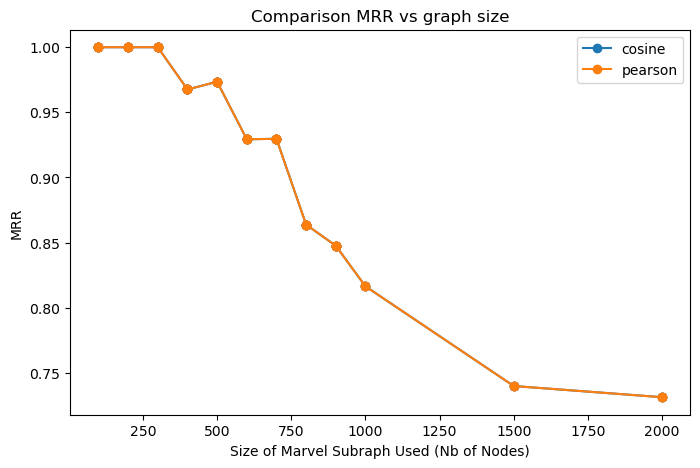

In [35]:
fig, ax = plt.subplots(figsize=(8,5))
for sim in methods:
    dfm = sorted_df[sorted_df['method']==sim]
    ax.plot(dfm['fraction'], dfm['MRR'], marker='o', label=sim)
ax.set_xlabel('Size of Marvel Subraph Used (Nb of Nodes)')
ax.set_ylabel('MRR')
ax.set_title('Comparison MRR vs graph size')
ax.legend()
plt.show()

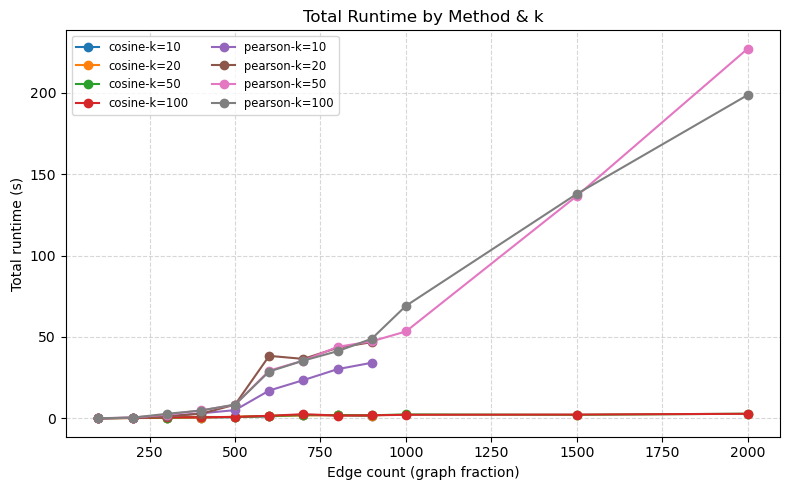

In [52]:
# runtime plot: total runtime vs. fraction for each (method, k)
plt.figure(figsize=(8,5))
for method in df['method'].unique():
    for k in df['k'].unique():
        label = f"{method}-k={k}"
        sub = df[(df['method']==method) & (df['k']==k)]
        # sort by fraction to ensure lines connect in order
        sub = sub.sort_values('fraction')
        plt.plot(sub['fraction'], sub['total_time_s'], marker='o', label=label)

plt.xlabel('Edge count (graph fraction)')
plt.ylabel('Total runtime (s)')
plt.title('Total Runtime by Method & k')
plt.legend(fontsize='small', ncol=2)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 5.1 LPFormer